In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(8000)

In [77]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\recon")
tracked_points_path = source_path / "trackedspots.xml"
save_path = source_path / "test_out"
save_path.mkdir(exist_ok=True)

In [ ]:
from src.utils.process_trackmate import process_trackmate_tree
from lxml import etree

tree = etree.parse(str(tracked_points_path))
spots_df, graph = process_trackmate_tree(tree)

print(len(list(graph.nodes)))

spots_df["track_id"] = spots_df["track_id"].astype(int)
plt.hist(spots_df.groupby("track_id")["FRAME"].min(), bins=100)
print(spots_df["FRAME"].max())
plt.show()

In [79]:
# spots_df.set_index("ID")
# spots_df["ID"] = spots_df.index
spots_df
print(spots_df.dtypes)
print(type(spots_df.index[0]))
# print(np.all(spots_df.index == spots_df["ID"]))

ID                       object
STD_INTENSITY_CH1       float64
QUALITY                 float64
POSITION_T              float64
MIN_INTENSITY_CH1       float64
TOTAL_INTENSITY_CH1     float64
CONTRAST_CH1            float64
SNR_CH1                 float64
FRAME                   float64
MEDIAN_INTENSITY_CH1    float64
VISIBILITY              float64
RADIUS                  float64
POSITION_X              float64
POSITION_Y              float64
MEAN_INTENSITY_CH1      float64
POSITION_Z              float64
MAX_INTENSITY_CH1       float64
track_id                  int32
position_cluster          int64
distance_from_edge      float64
dtype: object
<class 'numpy.int64'>


In [80]:
from src.models.division_tracking3d import interpolate_tracklets, merge_close_tracklets, quick_tracklets

# print(graph)
# 
# print(spots_df.index)
# spots_df, graph = interpolate_tracklets(spots_df, graph)
# 
# spots_df["track_id"] = spots_df["track_id"].astype(int)
# tracklets = quick_tracklets(spots_df)
# 
# 
# spots_df, graph = merge_close_tracklets(tracklets, spots_df, graph)

In [81]:
spots_df

,ID,STD_INTENSITY_CH1,QUALITY,POSITION_T,MIN_INTENSITY_CH1,TOTAL_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1,FRAME,MEDIAN_INTENSITY_CH1,VISIBILITY,RADIUS,POSITION_X,POSITION_Y,MEAN_INTENSITY_CH1,POSITION_Z,MAX_INTENSITY_CH1,track_id,position_cluster,distance_from_edge
0,0,19.370740,1.0,0.0,166.647247,34599.974838,0.021264,0.456340,0.0,213.001617,1.0,1.460033,162.405797,136.101449,212.269784,80.000000,260.418182,0,0,93.767160
1,1,2.134906,1.0,0.0,124.594231,21006.755234,-0.001967,-0.237967,0.0,128.608551,1.0,1.460033,177.875000,236.208333,128.875799,43.000000,135.257507,0,0,119.208733
2,2,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,0.0,0.000000,1.0,1.460033,285.256410,298.179487,0.000000,101.000000,0.000000,0,0,21.508628
5,5,0.766262,1.0,0.0,108.055588,18001.689148,-0.002175,-0.628248,0.0,110.368652,1.0,1.460033,98.224138,559.534483,110.439811,51.000000,113.468903,0,0,72.499995
6,6,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,0.0,0.000000,1.0,1.460033,91.354167,607.000000,0.000000,66.000000,0.000000,4,0,63.742842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457597,457595,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,252.898305,98.706897,0.000000,169.759156,0.000000,6122,0,5.107837
457598,457592,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,250.100962,867.833868,0.000000,261.023810,0.000000,6444,0,3.668241
457599,457593,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,247.000000,872.233333,0.000000,279.116667,0.000000,6521,0,4.539573
457600,457600,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,251.391667,93.411458,0.000000,209.543750,0.000000,649,0,3.975129


In [82]:
spots_df

,ID,STD_INTENSITY_CH1,QUALITY,POSITION_T,MIN_INTENSITY_CH1,TOTAL_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1,FRAME,MEDIAN_INTENSITY_CH1,VISIBILITY,RADIUS,POSITION_X,POSITION_Y,MEAN_INTENSITY_CH1,POSITION_Z,MAX_INTENSITY_CH1,track_id,position_cluster,distance_from_edge
0,0,19.370740,1.0,0.0,166.647247,34599.974838,0.021264,0.456340,0.0,213.001617,1.0,1.460033,162.405797,136.101449,212.269784,80.000000,260.418182,0,0,93.767160
1,1,2.134906,1.0,0.0,124.594231,21006.755234,-0.001967,-0.237967,0.0,128.608551,1.0,1.460033,177.875000,236.208333,128.875799,43.000000,135.257507,0,0,119.208733
2,2,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,0.0,0.000000,1.0,1.460033,285.256410,298.179487,0.000000,101.000000,0.000000,0,0,21.508628
5,5,0.766262,1.0,0.0,108.055588,18001.689148,-0.002175,-0.628248,0.0,110.368652,1.0,1.460033,98.224138,559.534483,110.439811,51.000000,113.468903,0,0,72.499995
6,6,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,0.0,0.000000,1.0,1.460033,91.354167,607.000000,0.000000,66.000000,0.000000,4,0,63.742842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457597,457595,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,252.898305,98.706897,0.000000,169.759156,0.000000,6122,0,5.107837
457598,457592,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,250.100962,867.833868,0.000000,261.023810,0.000000,6444,0,3.668241
457599,457593,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,247.000000,872.233333,0.000000,279.116667,0.000000,6521,0,4.539573
457600,457600,0.000000,1.0,0.0,0.000000,0.000000,NaN,NaN,268.0,0.000000,1.0,1.460033,251.391667,93.411458,0.000000,209.543750,0.000000,649,0,3.975129


268.0


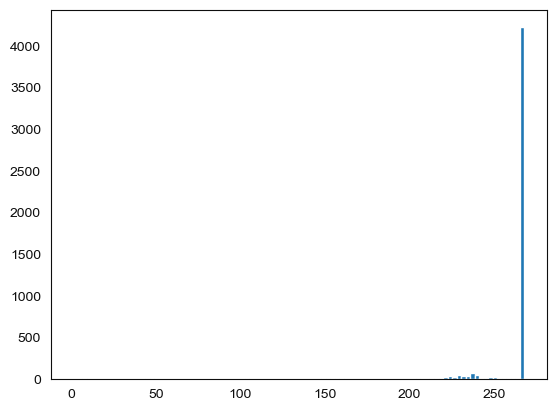

In [83]:
spots_df["track_id"] = spots_df["track_id"].astype(int)
plt.hist(spots_df.groupby("track_id")["FRAME"].max(), bins=100)
print(spots_df["FRAME"].max())
plt.show()

In [2]:
from src.models.division_tracking3d import map_divisions
from scripts.detect_divisions import process_graph

interphase_dividers = [53, 70, 115, 180, 267]
# interphase_dividers = [40, 70, 115, 180, 246]

new_graph = map_divisions(spots_df, graph, interphase_dividers, savepath=save_path, no_assign_dis_cost=100)


NameError: name 'spots_df' is not defined

In [85]:
tracked_df = process_graph(spots_df, new_graph)
print(tracked_df[tracked_df["FRAME"] == tracked_df["FRAME"].max()].groupby("track_id").size().value_counts())

tracked_df.to_csv(save_path / "new_tracked_spots.csv", index=True)

number of tracklets detected: 11349
1     472
2     152
6      47
4      46
12     37
8      37
10     29
14     27
13     26
16     25
11     20
15     19
7      19
3      13
9      11
5       9
Name: count, dtype: int64


In [86]:
import napari
from napari.utils.theme import get_theme, register_theme

viewer = napari.Viewer()

for df in [spots_df, tracked_df]:

    df["reflection_z"] = 2.1*df["POSITION_Z"].max() - df["POSITION_Z"]
    df["reflection_x"] = df["POSITION_X"].max() - df["POSITION_X"]
    
    df["is_reflected"] = df["POSITION_X"] > df["POSITION_X"].max() / 2
    
    df["display_x"] = df["reflection_x"]*df["is_reflected"] + df["POSITION_X"]*(~df["is_reflected"])
    df["display_z"] = df["reflection_z"]*df["is_reflected"] + df["POSITION_Z"]*(~df["is_reflected"])
    
    track_id = df["track_id"].unique()
    print(len(track_id))
    color_map = {track: g_palette[i % 8000] for i, track in enumerate(track_id)}
    color = [color_map[track] for track in df["track_id"]]
    
    viewer.add_points(df[["FRAME", "display_x", "POSITION_Y", "display_z"]],
                        face_color=color, size=13)

# blue_theme = get_theme('dark')
# blue_theme.id = 'blue' # or as list
# blue_theme.canvas = "#0A1121"
# register_theme('blue', blue_theme, 'custom')
viewer.theme = 'dark'

napari.run()

5179
3318


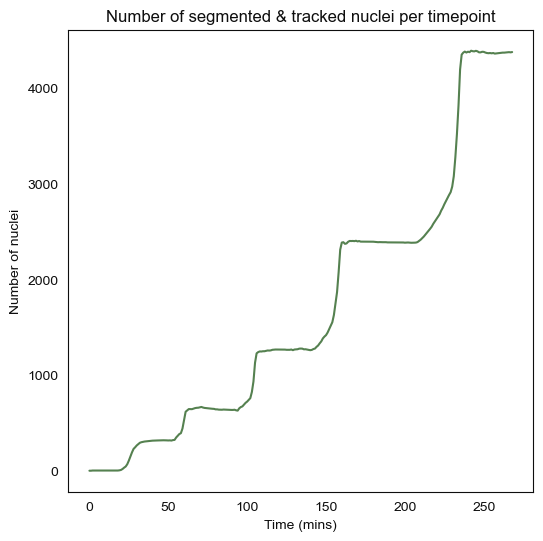

In [7]:
import plotly.express as px

tracked_df["reflection_z"] = 2.1*tracked_df["POSITION_Z"].max() - tracked_df["POSITION_Z"]
tracked_df["reflection_x"] = tracked_df["POSITION_X"].max() - tracked_df["POSITION_X"]

tracked_df["is_reflected"] = tracked_df["POSITION_X"] > tracked_df["POSITION_X"].max() / 2

tracked_df["display_x"] = tracked_df["reflection_x"]*tracked_df["is_reflected"] + tracked_df["POSITION_X"]*(~tracked_df["is_reflected"])
tracked_df["display_z"] = tracked_df["reflection_z"]*tracked_df["is_reflected"] + tracked_df["POSITION_Z"]*(~tracked_df["is_reflected"])

fig = px.scatter_3d(tracked_df, x='display_x', y='POSITION_Y', z='display_z', color='track_id', animation_frame="FRAME")

fig.update_layout(scene=dict(aspectmode='data'))
fig.write_html(save_path / "allspots.html")

n_tracks = 8000
best_spots = tracked_df[tracked_df["track_id"] > 0]
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
best_spots = best_spots[best_spots["FRAME"] > 10]
# best_spots = best_spots[best_spots["POSITION_X"] < 180]
# best_spots = best_spots[best_spots["POSITION_Y"] < 100]
fig = px.scatter_3d(best_spots, x='display_x', y='POSITION_Y', z='display_z', color='track_id', animation_frame="FRAME", animation_group="tracklet_id", color_continuous_scale=g_palette, range_color=[0, n_tracks])

fig.update_layout(scene=dict(aspectmode='data'))
fig.update_layout(transition={'duration': 100})
fig.update_traces(marker=dict(size=10, colorscale=g_palette), 
                  line=dict(width=50, color='DarkSlateGrey'),
                  )
fig.write_html(save_path / "track_bestspots.html")

plt.figure(figsize=(6, 6))
best_spots = tracked_df[tracked_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
sns.lineplot(best_spots.groupby("FRAME")["track_id"].count(), color=palette["green"])
plt.title("Number of segmented & tracked nuclei per timepoint")
plt.xlabel("Time (mins)")
plt.ylabel("Number of nuclei")
plt.grid(True, which="both")
plt.savefig(save_path / "nuclei_count.png", dpi=300)
plt.show()

In [7]:
# import napari
# from scipy.spatial import Delaunay
# 
# 
# napari_frames = [80, 120, 160, 215, 270]
# viewer = napari.Viewer()
# # 
# # napari_points = best_spots[best_spots["FRAME"] == 270].sample(500)[["POSITION_X", "POSITION_Y", "POSITION_Z"]].values
# # 
# # # contract towards middle
# # center = napari_points.mean(axis=0)
# # napari_points = center + 0.9*(napari_points - center)
# # tri = Delaunay(napari_points)
# # 
# # t_combs = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
# # shapes = []
# # for s in tqdm(tri.simplices):
# #     for comb in t_combs:
# #         shapes.append(napari_points[s[comb]])
# # viewer.add_shapes(shapes, shape_type="polygon", edge_color='white', face_color='white')
# 
# s = [24, 18, 16, 13, 10]
# 
# for frame, size in zip(napari_frames, s):
#     bs = best_spots[best_spots["FRAME"] == frame]
#     viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{frame}",
#                       face_color=[g_palette[track] for track in bs["track_id"]], size=size*1.2)
#     
# napari.run()

In [1]:
import napari
sz_start = 26
sz_end = 10
f_start = 20
f_end = 245
sz = np.linspace(sz_start, sz_end, f_end - f_start)
viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp"
tmppath.mkdir(exist_ok=True)

for s, frame in zip(sz, range(f_start, f_end)):
    bs = best_spots[best_spots["FRAME"] == frame]
    l = viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{frame}",
                      face_color=[g_palette[track] for track in bs["track_id"]], size=s, translate=[100, 0, 0])
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"))
    # l.visible = False
    l.refresh()

NameError: name 'np' is not defined

In [9]:
# import plotly.express as px
# 
# xrange = [points['x'].max(), points['x'].min()]
# yrange = [points['y'].max(), points['y'].min()]
# 
# fig = px.scatter_3d(points[points["val"] > 75], x='x', y='y', z='z', color='val', range_x=[0, 150], range_y=yrange, animation_frame="frame")
# fig.update_traces(marker=dict(size=5))
# 
# fig.write_html(save_path / "dog_lo3_hi5.html")

In [10]:
# n_tracks = int(max(tracked_points["TRACK_ID"]))
# g_palette = create_palette(n_tracks)

In [11]:
# import plotly.express as px
# 
# xrange = [points['x'].max(), points['x'].min()]
# yrange = [points['y'].max(), points['y'].min()]
# 
# fig = px.scatter_3d(points, x='x', y='y', z='z', color='val', range_x=xrange, range_y=yrange, animation_frame="frame")
# fig.update_traces(marker=dict(size=5))
# 
# fig.write_html(save_path / "dog_scatter.html")
# 
# fig = px.scatter_3d(tracked_points, x='POSITION_X', y='POSITION_Y', z='POSITION_Z', color='TRACK_ID', range_x=[0, 100], range_y=yrange, animation_frame="FRAME", color_continuous_scale=g_palette, range_color=[0, n_tracks])
# 
# # draw axes in proportion to the proportion of their ranges
# fig.update_layout(scene=dict(aspectmode='manual', aspectratio=dict(x=1, y=points['y'].max()/100, z=points['z'].max()/100)))
# 
# fig.update_traces(marker=dict(size=5, colorscale=g_palette))
# 
# fig.write_html(save_path / "tracked_scatter.html")
#     

In [12]:
# import napari
# from scipy.spatial.distance import cdist
# viewer = napari.Viewer(ndisplay=3)
# 
# bs = best_spots[best_spots["FRAME"] == 240]
# 
# roi = 40
# 
# locs = bs[["POSITION_X", "POSITION_Y", "POSITION_Z"]].values
# distances = cdist(locs, locs)
# density = np.sum(distances < roi, axis=1)
# 
# plt.hist(density, bins=100)
# plt.show()
# 
# ncolors = 20
# 
# density_max = np.quantile(density, 0.98)
# density_min = np.quantile(density, 0.02)
# 
# densities =  np.clip((density - density_min) / (density_max - density_min), 0, 1) 
# print(densities)
# # bs["density_binned"] = pd.cut(density, bins=ncolors)
# 
# pal = sns.color_palette("mako", as_cmap=True)
# 
# viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{270}", features={"density": densities},
#                       face_color="density", face_colormap="viridis", size=10)
# 
# napari.run()
